In [11]:
from helpers import *
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1. Get the data</h3>
    </span>
</div>
</div>

In [2]:
# get the data
articles, categories, links, paths_finished, paths_unfinished, paths_all, shortest_path_distance = load_data()

# #remove the paths that has only a starting point and are not of our interest
# paths_unfinished = paths_unfinished[paths_unfinished.pathLength > 1]

# Create the graphs of interest
G_paths, G_links = get_graphs(paths_all,links)
G_paths_finished, _ = get_graphs(paths_finished,links)
G_paths_unfinished, _ = get_graphs(paths_unfinished,links)

In [3]:
# Get the number of finished and unfinished node_visited 
nb_finished_node_visited = paths_finished.pathLength.sum()
nb_unfinished_node_visited = paths_unfinished.pathLength.sum()
print("There are %d node that were visited in finished path and %d in unfinished paths"%(nb_finished_node_visited, nb_unfinished_node_visited))

There are 346767 node that were visited in finished path and 124081 in unfinished paths


In [4]:
# Get all the stats from the graphs and the categories we need for the analysis
categories_all = get_all_features_of_categories(categories, G_paths_finished, G_paths_unfinished, nb_finished_node_visited, nb_unfinished_node_visited)
categories_all[['weighted_diff_mean_in_out', 'weighted_diff_finished', 'weighted_diff_unfinished']].head(5)

,weighted_diff_mean_in_out,weighted_diff_finished,weighted_diff_unfinished
splitted_cat,,,
Actors_models_and_celebrities,-0.089356,-0.276753,-0.370563
African_Countries,0.093909,0.043150,0.130787
African_Geography,0.118403,0.013205,0.123787
Air_and_Sea_transport,-0.036228,-0.020322,-0.111400
Ancient_History_Classical_History_and_Mythology,-0.011662,0.001311,0.008437


</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>2.1 Look at the difference between in and out degree in finished and unfinished paths </h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
         <h4>Motivation</h4> 
       We want to analysis where the player can get stuck during their games. For each wikipedia article, we have its in and our degree and these two values are not always the same because when we constructed the graph we remove edges that went back to the previous pages visited (when players went bakc to the prvevious page. We can now use this fact to see where people get stuck. 
       <br> In fact when we compute the difference $\delta = in_{deg}- out_{deg}$ we can haev to cases : 
        <ul>
            <li>if $\delta$ is big, it means that we came to this node but then came back to the previous one - the player though the he/she was on the wrong way</li>
            <li>if $\delta$ is small, it means that we get back and forth from this node not knowing how to escape - the player think he is at a key node but don't know how to go further</li>
        </ul>
        <h4>Plots</h4>         
First, we see that nodes for finished paths are more balanced, which means the go back button was not used much in these concepts, whereas for unfinished paths it is skewed right but also to the left.
<h4>Unfinished paths</h4> 
From this we see that we have both cases with unfinished paths ($\delta$ is big and $\delta$ is small) and what is interesting is that the 
        <ul>
            <li>the node they go to and then come back are the node used more in finished paths like politics/history/chemistry, which means that maybe they don't adopt the good strategy and should have continued in this direction.</li>
            <li>the node they cannot escape are the ones related to litterature which are the node used less in finished than in unfinished. So we might conclude that the players should escape these node as soon as possible.</li>
        </ul>
    </span>
</div>

(splitted_cat
 General_Chemistry                                          0.302968
 Chemical_elements                                          0.268312
 British_History_1500_and_before_including_Roman_Britain    0.259631
 Chemistry                                                  0.243379
 Software                                                   0.237548
 Middle_Eastern_Countries                                   0.230772
 Musical_Instruments                                        0.226893
 Monarchs_of_Great_Britain                                  0.215164
 Geography_of_the_Middle_East                               0.202387
 World_War_II                                               0.200879
 Name: weighted_diff_unfinished, dtype: float64,
 splitted_cat
 Theatre                                 -0.961289
 Architecture                            -0.901713
 Literature_types                        -0.855537
 Cartoons                                -0.728956
 Producers_directors_and_medi

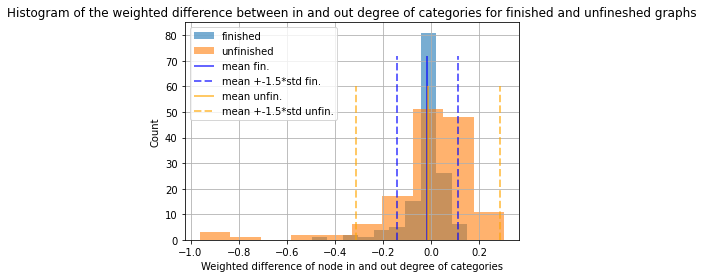

In [12]:
categories_all.weighted_diff_finished.hist(alpha = 0.6, label = 'finished').set_title('Histogram of the weighted difference between in and out degree of categories for finished and unfineshed graphs')
categories_all.weighted_diff_unfinished.hist(alpha = 0.6, label = 'unfinished')

plt.xlabel('Weighted difference of node in and out degree of categories')
plt.ylabel('Count')
mean_fin, std_fin = categories_all.weighted_diff_finished.mean(), categories_all.weighted_diff_finished.std()
mean_unfin, std_unfin = categories_all.weighted_diff_unfinished.mean(), categories_all.weighted_diff_unfinished.std()

val_frac_start = 1.5
y_limit = 60
plt.vlines(mean_fin, 0, y_limit*1.2, ls='-',alpha = 0.6, color='blue', linewidth=2, label = 'mean fin.')
plt.vlines(mean_fin+ val_frac_start *std_fin,  0, y_limit*1.2, ls='--',alpha = 0.6, color='blue', linewidth=2,label ='mean +-'+str(val_frac_start)+'*std fin.')
plt.vlines(mean_fin- val_frac_start * std_fin,  0, y_limit*1.2, ls='--',alpha = 0.6, color='blue', linewidth=2)
plt.vlines(mean_unfin, 0, y_limit, ls='-',alpha = 0.6, color='orange', linewidth=2, label = 'mean unfin.')
plt.vlines(mean_unfin+ val_frac_start *std_unfin,  0, y_limit, ls='--',alpha = 0.6, color='orange', linewidth=2,label ='mean +-'+str(val_frac_start)+'*std unfin.')
plt.vlines(mean_unfin- val_frac_start * std_unfin,  0, y_limit, ls='--',alpha = 0.6, color='orange', linewidth=2)
plt.legend()
get_first_last(10, categories_all, 'weighted_diff_unfinished')

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>2.2 Comparing topics of starting and target pages</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        <h4>Plots</h4> 
       We plot two histograms 
        <ul>
            <li>the histogram of the sucess rate of a concept as <b>starting page</b></li>
            <li>the histogram of the sucess rate of a concept as <b>target page</b>.</li>  
        </ul>
        <h4>Starting page</h4> 
        First we see that the starting page histogram has a smaller variance then the target page histogram. It is not a surprise since we know that the starting phase of going to a hub is the easiest part. Moreover we cannot say that a starting page is easier but there are still some pages that seems harder to start with  <code class='python'>['Architecture', 'Theatre', 'Literature_types', 'General_Biology', 'Language_and_literature', 'Design_and_Technology', 'Air_and_Sea_transport', 'Conflict_and_Peace']</code>. In particular, starting with the topic <code class='python'>Architecture</code> lead to a probability of sucess of $0.26$ which means that the game is finished once over 4 attempts.
        <h4>Target page </h4>  
        In the target page histogram, we can see a lot of variance and there are topics that seems to be easier or harder than others. We can see that topics with <i>Geography</i> or <i>Countries</i> are quiet easy. Topics as <code class='python'>European_Countries, USA_Presidents, European_Geography</code> are finished more than 4 times over 5 attemps. <br>
        On the other side, topics more related to <i>Movies</i> or <i>Litterature</i> are harder. For example, the topic <code class='python'>General_Literature</code> has a score of $0.08$ which mean that a game is finished less than 1 times over 10 with this concept as target.
        <h4>Conlusion </h4>  
        Some starting and target concepts has a big impact on the result of a game. We will use these two score for our logistic regression.
    </span>
</div>

In [13]:
# split the categories and and aggregate categories of articles that have multiple categories
categories['categories'] = categories.category.apply(lambda x : x.split('.')[1:])
categories_merged = pd.DataFrame(categories.groupby('article').categories.agg(sum))
start_target_cats = get_start_target_cats(paths_unfinished, paths_finished, categories_merged, nb_finished_node_visited, nb_unfinished_node_visited)
start_target_cats.head(4)

,start_finished,target_finished,start_unfinished,target_unfinished,weighted_diff_start,weighted_diff_target,frac_start,frac_target
start_cats,,,,,,,,
Actors_models_and_celebrities,0.637316,0.259540,0.604444,1.378132,0.026472,-0.683038,0.513236,0.158481
African_Countries,1.626452,2.309908,1.531258,0.628622,0.030147,0.572152,0.515073,0.786076
African_Geography,3.751799,4.565025,3.296234,1.378132,0.064637,0.536229,0.532319,0.768114
Air_and_Sea_transport,0.700759,0.542151,1.023525,0.539970,-0.187189,0.002015,0.406406,0.501008


(start_cats
 Engineers_and_inventors                     0.614189
 The_Planets                                 0.610307
 Natural_Disasters                           0.588696
 Human_Scientists                            0.577024
 Cryptography                                0.572984
 Computer_and_Video_games                    0.566904
 Middle_Eastern_Countries                    0.562389
 Philosophers                                0.560390
 Historians_chroniclers_and_history_books    0.556025
 Antarctica                                  0.554339
 Name: frac_start, dtype: float64,
 start_cats
 Architecture               0.269728
 Theatre                    0.332606
 Literature_types           0.339720
 Design_and_Technology      0.369822
 General_Biology            0.370208
 Language_and_literature    0.375752
 Air_and_Sea_transport      0.406406
 Conflict_and_Peace         0.414149
 Animal_and_Human_Rights    0.423541
 Storms                     0.438569
 Name: frac_start, dtype: float

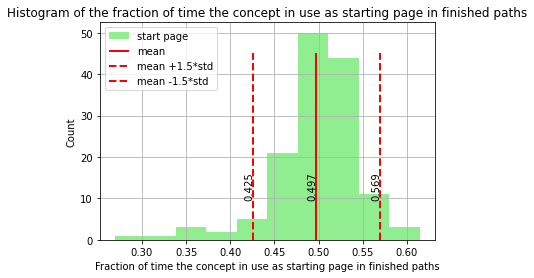

In [14]:
start_target_cats['frac_start'].hist(label = 'start page', color = 'lightgreen')\
            .set_title("""Histogram of the fraction of time the concept in use as starting page in finished paths""")
plt.xlabel('Fraction of time the concept in use as starting page in finished paths')
plt.ylabel('Count')
mean_frac_start, std_frac_start = start_target_cats['frac_start'].mean(), start_target_cats['frac_start'].std()

val_frac_start = 1.5
y_limit = 45
plt.vlines(mean_frac_start, 0, y_limit, ls='-', color='red', linewidth=2, label = 'mean')
plt.text(mean_frac_start- 0.01,10,'%.3f'%(mean_frac_start),rotation=90)
plt.vlines(mean_frac_start+ val_frac_start *std_frac_start,  0, y_limit, ls='--', color='red', linewidth=2,label ='mean +'+str(val_frac_start)+'*std')
plt.text(mean_frac_start+ val_frac_start *std_frac_start- 0.01,10,\
            '%.3f'%(mean_frac_start+ val_frac_start *std_frac_start),rotation=90)
plt.vlines(mean_frac_start- val_frac_start * std_frac_start,  0, y_limit, ls='--', color='red', linewidth=2, label ='mean -'+str(val_frac_start)+'*std')
plt.text(mean_frac_start- val_frac_start *std_frac_start- 0.01,10,\
            '%.3f'%(mean_frac_start- val_frac_start *std_frac_start),rotation=90)
plt.legend()

get_first_last(10, start_target_cats, 'frac_start')

(start_cats
 European_Countries              0.850395
 USA_Presidents                  0.828968
 European_Geography              0.804207
 Asian_Countries                 0.795314
 Middle_Eastern_Countries        0.786535
 African_Countries               0.786076
 Countries                       0.785872
 Languages                       0.779158
 African_Geography               0.768114
 Geography_of_the_Middle_East    0.766678
 Name: frac_target, dtype: float64,
 start_cats
 General_Literature                       0.088525
 Cartoons                                 0.157733
 Actors_models_and_celebrities            0.158481
 Games                                    0.186206
 Conflict_and_Peace                       0.189713
 Novels                                   0.203694
 Sports_and_games_people                  0.245845
 Television                               0.248437
 Community_organisations                  0.251930
 Producers_directors_and_media_figures    0.254799
 Name: fra

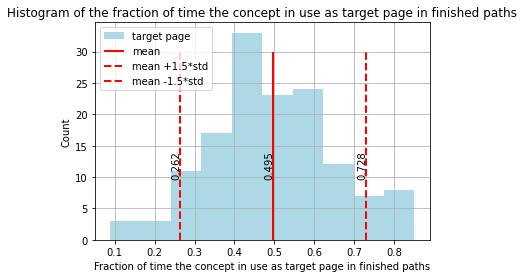

In [15]:
# Look at the target page now
start_target_cats['frac_target'].hist(label = 'target page', color = 'lightblue')\
            .set_title("""Histogram of the fraction of time the concept in use as target page in finished paths""")
plt.xlabel('Fraction of time the concept in use as target page in finished paths')
plt.ylabel('Count')
mean_frac_target, std_frac_target = start_target_cats['frac_target'].mean(), start_target_cats['frac_target'].std()

val_frac_target = 1.5
y_limit = 30
plt.vlines(mean_frac_target, 0, y_limit, ls='-', color='red', linewidth=2, label = 'mean')
plt.text(mean_frac_target- 0.02,10,'%.3f'%(mean_frac_target),rotation=90)
plt.vlines(mean_frac_target+ val_frac_target *std_frac_target,  0, y_limit, ls='--', color='red', linewidth=2,label ='mean +'+str(val_frac_target)+'*std')
plt.text(mean_frac_target+ val_frac_target *std_frac_target- 0.02,10,\
            '%.3f'%(mean_frac_target+ val_frac_target *std_frac_target),rotation=90)
plt.vlines(mean_frac_target- val_frac_target * std_frac_target,  0, y_limit, ls='--', color='red', linewidth=2, label ='mean -'+str(val_frac_target)+'*std')
plt.text(mean_frac_target- val_frac_target *std_frac_target- 0.02,10,\
            '%.3f'%(mean_frac_target- val_frac_target *std_frac_target),rotation=90)
plt.legend()
# Get the easiest and hardest finishing pages
get_first_last(10, start_target_cats, 'frac_target')

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>2.3 Plots</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We plot the impact on the starting and the target paths to suceed finishing the game. 
        <br>In <b>red</b> are concepts that have bad impact on finishing a game and in <b>green</b> good impact. This is determined if the score of the starting or target concept is out of 1.5 its standard deviation of its mean.
    </span>
</div>


In [16]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool, ColorBar, ColorMapper,Range1d
output_notebook()
def get_color_2(x):
    if x.frac_target < mean_frac_target-val_frac_target*std_frac_target \
            or x.frac_start < mean_frac_start-val_frac_start*std_frac_start :
        return 'red'
    elif x.frac_target > mean_frac_target+val_frac_target*std_frac_target \
            or x.frac_start > mean_frac_start+val_frac_start*std_frac_start :
        return 'green'
    else :
        return 'blue'
data = start_target_cats[['frac_start', 'frac_target']].reset_index()
data['color'] = data.apply(lambda x : get_color_2(x), axis = 1)
hover = HoverTool(
    tooltips=[
        ("Name", "@start_cats"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=660, plot_height=460, tools=tools, title="Comparing sucess of game with start and target topics")
p.title.text_color = "black"
p.title.text_font_size = "15px"
p.xaxis.axis_label = 'Sucess rate with this concept as starting edges'
p.yaxis.axis_label = 'Sucess rate with this concept as target edges'
p.x_range = Range1d(0,1)
p.y_range = Range1d(0,1)

p.circle('frac_start', 'frac_target', color = 'color', source=data, size=15, alpha=0.5)

show(p, notebook_handle=True)

Loading BokehJS ...

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>3.1 Add fetures to the data</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We add the features to the data so that we can used the score computed for the starting and target page in our final logistic regression.
    </span>
</div>

In [9]:
# Get the categories corresponding to the article and aggregate them by a sum if multiple
categories['categories'] = categories.category.apply(lambda x : [x.split('.')[-1]])
categories_merged_2 = pd.DataFrame(categories.groupby('article').categories.agg(sum))

# Create the df with all the features
features = paths_all.sort_values(by='timestamp').groupby('hashedIpAddress').last()
features['starting'] = features.path.apply(lambda x : x.split(';')[0])
features['target'] = features['target'].apply(lambda t : get_score(t, 'frac_target', categories_merged_2, start_target_cats))
features['starting'] = features['starting'].apply(lambda t : get_score(t, 'frac_start', categories_merged_2, start_target_cats))
features = features[['starting', 'target']]
features.head(4)

,starting,target
hashedIpAddress,,
000386124f307de8,0.269728,0.616963
0007183207b6008f,0.469875,0.785974
000a09e202e88d10,0.533556,0.679462
000a5bac5b7781ea,0.423541,0.436056


In [ ]:
import pandas as pd
others_feat = pd.read_csv("data/features.csv", encoding = 'utf-8', index_col = 'hashedIpAddress')
final = others_feat.join(features)
final.to_csv("data/features_cluster_pages.csv", index = True)